<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basic-image-statistics" data-toc-modified-id="Basic-image-statistics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basic image statistics</a></span><ul class="toc-item"><li><span><a href="#Weighted-averages" data-toc-modified-id="Weighted-averages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Weighted averages</a></span></li><li><span><a href="#Verify-with-random-numbers" data-toc-modified-id="Verify-with-random-numbers-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Verify with random numbers</a></span></li><li><span><a href="#Example:-Far-infrared-images-of-the-GN-z11-field" data-toc-modified-id="Example:-Far-infrared-images-of-the-GN-z11-field-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Example: Far-infrared images of the GN-z11 field</a></span><ul class="toc-item"><li><span><a href="#Question:" data-toc-modified-id="Question:-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Question:</a></span></li></ul></li></ul></li><li><span><a href="#Hubble-Space-Telescope-images" data-toc-modified-id="Hubble-Space-Telescope-images-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hubble Space Telescope images</a></span><ul class="toc-item"><li><span><a href="#Source-detection-and-image-segmentation" data-toc-modified-id="Source-detection-and-image-segmentation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Source detection and image segmentation</a></span><ul class="toc-item"><li><span><a href="#Question:" data-toc-modified-id="Question:-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Question:</a></span></li></ul></li></ul></li></ul></div>

# Basic image statistics

This notebook shows some basic tools for interpreting telescope images of distant galaxies, taking the example of the distant galaxy GNz11 in the "GOODS-North" survey field from the Hubble Space telescope [(Oesch et al. 2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...819..129O/abstract).

In [1]:
!pip install scikit-image

In [30]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.interpolation'] = 'Nearest'
plt.rcParams['image.origin'] = 'lower'

import scipy.stats

## Weighted averages

We'll use a simple technique throughout to compute weighted averages of quantities where we have (1D, 2D) arrays of noisy measurements and corresponding arrays of the uncertainties estimated from knowledge of the detector characteristics.  

For convenience, we'll frequently define inverse variance weight arrays

$\mathrm{w} = 1/\sigma^2$, 

so that dividing by $\sigma^2$ is rather a multiplicative operation (and where missing data is naturally described by $\mathrm{w} = 0$.

For data $x_i$ with weights $w_i = 1 / \sigma_i^2$, the weighted average of $x$ is

$\bar x = \sum(x_i w_i) / \sum(w_i)$. 

with variance

$s^2 = 1 / \sum(w_i)$.

## Verify with random numbers

In [31]:
Ndraws = 10000
Ntrials = 1000

xbar = np.zeros(Ntrials)
s2 = np.zeros(Ntrials)

for i in range(Ntrials):
    # Unequal uncertainties
    sig = np.random.rand(Ndraws)+1
    rvs = np.random.normal(size=Ndraws)*sig
    w = 1/sig**2
    xbar[i] = (rvs*w).sum()/w.sum()
    s2[i] = 1/w.sum()
    

AndersonResult(statistic=0.20274729418576953, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

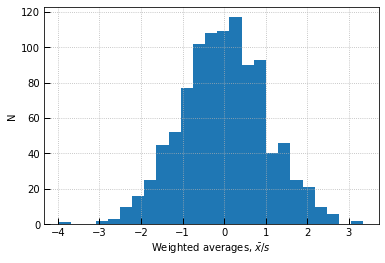

In [34]:
# Are the computed averages normally distributed given 
# their calculated variances?
_h = plt.hist(xbar/np.sqrt(s2), bins=25)
plt.grid()
plt.xlabel(r'Weighted averages, $\bar{x}/s$')
plt.ylabel('N')

scipy.stats.anderson(xbar/np.sqrt(s2))

## Example: Far-infrared images of the GN-z11 field

The field around GN-z11 was observed with the Scuba2 instrument on the James Clerk Maxwell telescope at a wavelength of 850 µm.  The background at these wavelengths is generally **much** brighter than the sources of interest, so many exposures are taken and averaged to make the final map.

In [45]:
# Image data
scuba2 = np.load('scuba2.npy', allow_pickle=True)[0]
print('Keys: ', scuba2.keys())
for k in scuba2:
    print(k, scuba2[k].shape)
    
Nexp, ydim, xdim = scuba2['intensity'].shape

Keys:  dict_keys(['intensity', 'weight', 'exposure_time'])
intensity (275, 72, 72)
weight (275, 72, 72)
exposure_time (275,)


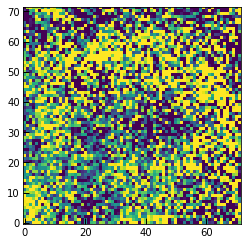

In [46]:
# Show the first exposure
plt.imshow(scuba2['intensity'][0,:,:], vmin=-10, vmax=10)

AndersonResult(statistic=0.22654166802931286, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

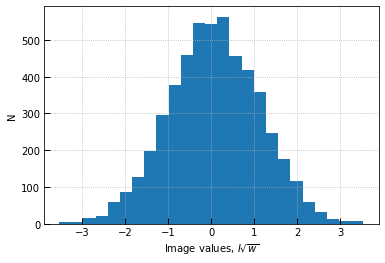

In [69]:
# Is the noise of a single exposure Gaussian?
scaled_noise = scuba2['intensity']*np.sqrt(scuba2['weight'])
_h = plt.hist(scaled_noise[0,:,:].flatten(), bins=25)

plt.grid()
plt.xlabel(r'Image values, $I \sqrt{w}$')
plt.ylabel('N')

scipy.stats.anderson(scaled_noise[0,:,:].flatten())


In [47]:
# Cumulative weighted average
cumul_num = np.cumsum(scuba2['intensity']*scuba2['weight'], axis=0)
cumul_den = np.cumsum(scuba2['weight'], axis=0)

cumul_intensity = cumul_num/cumul_den
cumul_var = 1/cumul_den

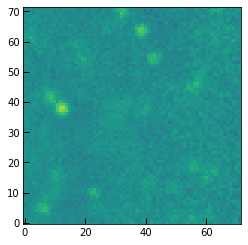

In [48]:
# Show the final weighted image
plt.imshow(cumul_intensity[-1,:,:], vmin=-10, vmax=10)

How does the median weight ($1/s^2$) of the weighted stack 
change with time?

We found that signal-to-noise ($\bar{x}/s$) goes as $\sqrt t$, so weight should increase linearly in time.

In [57]:
cumul_weight = 1/cumul_var # = cumul_den = sum of weights

median_wht = [np.median(cumul_weight[i,:,:]) for i in range(Nexp)]

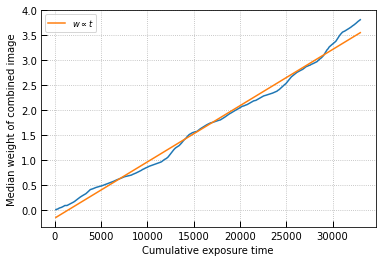

In [55]:
# Fit with a line (weight linear in time is 1/sqrt(s) time as expected
cumul_time = np.cumsum(scuba2['exposure_time'])

plt.plot(cumul_time, median_wht)

_c = np.polyfit(cumul_time, median_wht, 1)
plt.plot(cumul_time, np.polyval(_c, cumul_time), label=r'$w\propto t$')
plt.xlabel('Cumulative exposure time')

plt.ylabel('Median weight of combined image')

plt.legend()
plt.grid()

### Question:

Is the noise of the stack Gaussian?

# Hubble Space Telescope images

The data provided here are cutouts from Hubble images around the position of the galaxy GN-z11.  Images are provided in four bandpass filters, named like 

- f105w: Centered at 1.05 µm
- f125w: 1.25 µm
- f140w: 1.40 µm
- f160w: 1.60 µm


In [82]:
hst_data = np.load('gnz11-hst_cutouts.npy', allow_pickle=True)[0]

galaxy_models, psfs, flux_scale, exptime = np.load('gnz11-hst_extra.npy', 
                                                   allow_pickle=True)
print(hst_data.keys())
print(hst_data['f160w'].keys())

hst_dim = image_models['f160w'].shape
print('Image dimensions: ', hst_dim)

dict_keys(['f105w', 'f125w', 'f140w', 'f160w'])
dict_keys(['intensity', 'weight'])
Image dimensions:  (240, 240)


## Source detection and image segmentation

Make a threshold image that provides an estimate of the S/N of a point source at every position in the image. 

Then run peak-finding and segmentation algorithms to "segment" the image into discrete sources (e.g., [skimage.segmentation.watershed](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html)).

In [83]:
# Segmentation
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import binary_dilation

from scipy import ndimage as ndi

peak_threshold = 7
segment_threshold = 2.5

#peak_threshold = 3
#segment_threshold = 1.2

# Run detection on F160W image
filt = 'f160w'

/Users/gbrammer/miniconda3/envs/grizli-dev-2020.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


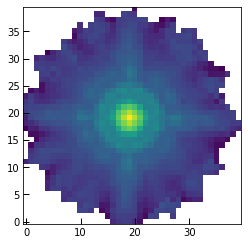

In [86]:
# Show a PSF
plt.imshow(np.log10(psfs['f160w']))

In [87]:
from scipy.signal import fftconvolve

# SN image: intensity convolved with the PSF
psf = psfs[filt]
data = hst_data[filt]

sm_num = fftconvolve(data['intensity']*data['weight'], psf, mode='same')
sm_den = fftconvolve(data['weight'], psf**2, mode='same')
SN = sm_num/np.sqrt(sm_den)


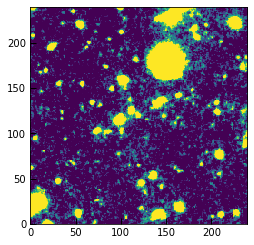

In [89]:
plt.imshow(SN, vmin=0, vmax=5)

In [93]:
# Find local maxima (sources) above the defined threshold
coords = peak_local_max(SN, footprint=np.ones((5, 5)), 
                        threshold_abs=peak_threshold, 
                        labels=None)

# Point labels
peak_mask = np.zeros(SN.shape, dtype=bool)
peak_mask[tuple(coords.T)] = True
markers, _ = ndi.label(peak_mask)

# Mask for segmentation
SN_mask = SN > segment_threshold

labels = watershed(-SN, markers, mask=SN_mask)

# Grow the segments slightly
grow = np.ones((3,3), dtype=bool)
empty = binary_dilation(labels > 0, selem=grow) == 0

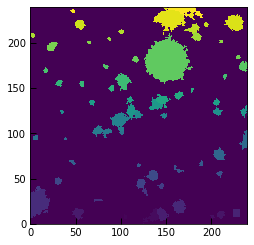

In [94]:
plt.imshow(labels)

In [95]:
# Is the noise Gaussian?

AndersonResult(statistic=0.2750565048866065, critical_values=array([0.573, 0.653, 0.784, 0.914, 1.087]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

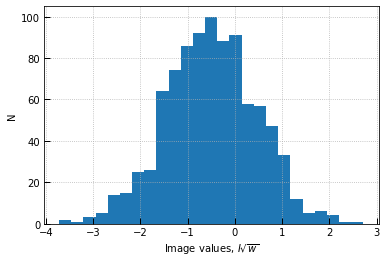

In [97]:
# Subregion that looks empty
slx = slice(58, 93)
sly = slice(39, 65)

_h = plt.hist(SN[sly, slx].flatten(), bins=25)

plt.grid()
plt.xlabel(r'Image values, $I \sqrt{w}$')
plt.ylabel('N')

scipy.stats.anderson(SN[sly, slx].flatten())

### Question:

1) Are empty parts of the entire image consistent with Gaussian noise?  
2) If not, why might that be?

In [ ]:
# use "empty" mask created above as the empty part of th eimag